_Ref: https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f_

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

# Load and transform

In [3]:
df=pd.read_csv('/content/drive/MyDrive/Intro_DS_2021/Preprocessing Data/SAVA_preprocessed.csv')
print('Number of rows and columns:', df.shape)
length = df.shape[0]
print(len)
df.head()

Number of rows and columns: (5281, 7)
<built-in function len>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-11-27,135.73,136.50,135.63,135.63,79.04,700
1,2000-11-28,133.00,135.63,131.25,131.25,76.49,929
2,2000-11-29,131.25,133.00,112.00,122.94,71.64,3229
3,2000-11-30,119.00,120.75,107.19,112.00,65.27,2186
4,2000-12-01,112.00,115.50,110.25,115.50,67.31,6243


`close_log`: $log\frac{Price_t}{Price_{t-1}}\;\;\;\;\;$
`target_log`: $log\frac{Price_{t+33}}{Price_{t+28}}$

In [4]:
seq_length = 30
step_predict = 5

In [5]:
df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
df['vol_log'] = np.log(df['Volume'] / df['Volume'].shift(1))
df['target_log'] = np.log(df['Close'].shift(-step_predict) / df['Close'])

In [6]:
train_df = df[int(length*0.7):int(length*0.9)].copy()
train_df.reset_index(inplace=True)
val_df = df[int(length*0.9):int(length*0.95)].copy()
val_df.reset_index(inplace=True)
test_df = df.loc[int(length*0.95):].copy()
test_df.reset_index(inplace=True)
train_df.shape, val_df.shape, test_df.shape

((1056, 11), (264, 11), (265, 11))

`sequence`: $\left[log\frac{Price_t}{Price_{t-1}},log\frac{Price_{t+1}}{Price_{t}}, \dots,log\frac{Price_{t+28}}{Price_{t+27}}\right]$

In [7]:
X_train = []
y_train = []
for i in range(seq_length, train_df.shape[0]-step_predict):
    X_train.append(train_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_train.append(train_df.loc[i-1, 'target_log'])
X_train, y_train= np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_train.shape, y_train.shape

((1021, 29, 2), (1021,))

In [8]:
X_val = []
y_val = []
for i in range(seq_length, val_df.shape[0]-step_predict):
    X_val.append(val_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_val.append(val_df.loc[i-1, 'target_log'])
X_val, y_val= np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 2))
X_val.shape, y_val.shape

((229, 29, 2), (229,))

# Model

In [9]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
inputs = Input(shape=(X_train.shape[1], 2))
lstm1 = LSTM(units=50, return_sequences=True)(inputs)
dropout1 = Dropout(rate=0.5)(lstm1)
lstm2 = LSTM(units=50, return_sequences=True)(dropout1)
dropout2 = Dropout(rate=0.5)(lstm2)
lstm3 = LSTM(units=50)(dropout2)
dropout3 = Dropout(rate=0.5)(lstm3)
fc1 = Dense(units=100)(dropout3)
fc2 = Dense(units=50)(fc1)
fc3 = Dense(units=25)(fc2)
output = Dense(units=1)(fc3)

lstm_model = Model(inputs=inputs, outputs=output)
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_val, y_val))

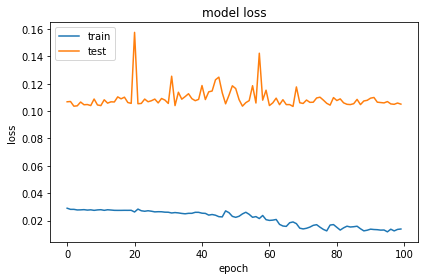

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Intro_DS_2021/Comparison/LSTM_loss.jpg")
plt.show()

# Predict and plot

### Train set

In [13]:
train_price = train_df[seq_length+step_predict:train_df.shape[0]].Close
train_predicted = lstm_model.predict(X_train)
# train_predicted = sc.inverse_transform(train_predicted)
inv = train_df[seq_length:train_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
train_predicted = inv * np.exp(1)**train_predicted
len(train_price), len(train_predicted)

(1021, 1021)

In [ ]:
# Visualising the results
date = train_df[seq_length+step_predict:train_df.shape[0]].Date.values
plt.figure(figsize=(20,10))
plt.plot(date, train_price, color = 'red', label = 'Real SAVA')
plt.plot(date, train_predicted, color = 'blue', label = 'Predicted SAVA')
plt.xticks(np.arange(0,len(train_predicted),100))
plt.title('TRAIN SET: SAVA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SAVA Stock Price')
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Intro_DS_2021/Comparison/LSTM_train_result.jpg")
plt.show()
print(f'RMSE: {mean_squared_error(train_price, train_predicted, squared=False)}')

### Val set

In [15]:
val_price = val_df[seq_length+step_predict:val_df.shape[0]].Close
val_predicted = lstm_model.predict(X_val)
# val_predicted = sc.inverse_transform(val_predicted)
inv = val_df[seq_length:val_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
val_predicted = inv * np.exp(1)**val_predicted
len(val_price), len(val_predicted)

(229, 229)

In [ ]:
# Visualising the results
date = val_df[seq_length+step_predict:val_df.shape[0]].Date.values
plt.figure(figsize=(20,10))
plt.plot(date, val_price, color = 'red', label = 'Real SAVA')
plt.plot(date, val_predicted, color = 'blue', label = 'Predicted SAVA')
plt.xticks(np.arange(0,len(val_predicted),50))
plt.title('VAL SET: SAVA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SAVA Stock Price')
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Intro_DS_2021/Comparison/LSTM_validation_result.jpg")
plt.show()
print(f'RMSE: {mean_squared_error(val_price, val_predicted, squared=False)}')

### Test set

In [18]:
# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'close_log'] = x

# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'vol_log'] = x

# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'target_log'] = x

In [19]:
X_test = []
y_test = []
for i in range(seq_length, test_df.shape[0]-step_predict):
    X_test.append(test_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_test.append(test_df.loc[i-1, 'target_log'])
X_test, y_test= np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
X_test.shape, y_test.shape

((230, 29, 2), (230,))

In [20]:
test_price = test_df[seq_length+step_predict:test_df.shape[0]].Close
test_predicted = lstm_model.predict(X_test)
# test_predicted = sc.inverse_transform(test_predicted)
inv = test_df[seq_length:test_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
test_predicted = inv * np.exp(1)**test_predicted
len(test_price), len(test_predicted)

(230, 230)

In [ ]:
# Visualising the results
date = test_df[seq_length+step_predict:test_df.shape[0]].Date.values
plt.figure(figsize=(20,10))
plt.plot(date, test_price, color = 'red', label = 'Real SAVA')
plt.plot(date, test_predicted, color = 'blue', label = 'Predicted SAVA')
plt.xticks(np.arange(0,len(test_predicted),50))
plt.title('TEST SET: SAVA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SAVA Stock Price')
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Intro_DS_2021/Comparison/LSTM_test_result.jpg")
plt.show()
print(f'RMSE: {mean_squared_error(test_price, test_predicted, squared=False)}')
print(f'MSE: {mean_squared_error(test_price, test_predicted)}')
print(f'MAE: {mean_absolute_error(test_price, test_predicted)}')